<a href="https://colab.research.google.com/github/Uniholder/DeepLearningSchool/blob/main/week3_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [ ]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from itertools import tee

In [ ]:
plt.rcParams['figure.figsize'] = (13, 8)

In [ ]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [ ]:
def session_string(session_it, session_length):
    '''
    Генератор
    Принимает итератор по файлу
    Возвращает строку
    '''
    try:
        for i in range(session_length):
            yield next(session_it)
    except StopIteration:
        return

In [ ]:
def feature_engineering(file, session_length, window_size, site_map, user_id):
    '''
    Генератор
    Создаёт массив признаков пользователя
    session_length: длина сессии
    window_size: длина шага
    site_map: словарь сайтов в формате 'site': site_id
    user_id: целевой признак
    '''
    windows_it = iter(file) # итератор по всему файлу (по строкам)
    i = 0

    while True:
        try:
            if i % window_size == 0: # начинаем писать сессию
                # разделяем итератор на два; новый итератор только по сессии (как вложенный цикл)
                windows_it, session_it = tee(windows_it)
                session = list(session_string(session_it, session_length))
                if session: # чтобы не возвращать в конце пустую строку
                    # обрабатываем сайты
                    sites_fact = list(map(lambda x: x.split(',')[1].strip(), session))
                    sites_ids = np.array([site_map[site] for site in sites_fact])
                    # список сайтов
                    sites = np.zeros(session_length)
                    sites[:len(sites_fact)] = sites_ids
                    # число уникальных сайтов
                    n_unique_sites = np.unique(sites_ids).size
                    
                    # обрабатываем timestamp'ы
                    times_fact = list(map(lambda x: pd.to_datetime(x.split(',')[0].strip()), session))
                    timediffs = np.array([(times_fact[i+1] - times_fact[i]).seconds for i in range(len(times_fact) - 1)])
                    # список разниц времён - по сути время посещения каждого сайта (кроме последнего)
                    times = np.zeros(session_length - 1)
                    times[:len(timediffs)] = timediffs
                    # длина сессии (минус время посещения последнего сайта)
                    session_timespan = (times_fact[-1] - times_fact[0]).seconds
                    # час начала сессии
                    start_hour = times_fact[0].hour
                    # день недели начала сессии
                    start_day_of_week = times_fact[0].weekday()
                    
                    yield np.concatenate((sites, times, [session_timespan], [n_unique_sites], 
                                          [start_hour], [start_day_of_week], [user_id]))
        except StopIteration:
            return

        try:
            next(windows_it)
            i += 1
        except StopIteration:
            return

In [ ]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    '''
    Преобразует набор файлов в датасет: строка - сессия
    '''
    
    train_set, user_ids = [], []

    # скачиваем словарь сайтов
    site_dict = pd.read_pickle(site_freq_path)
    site_map = {k: v[0] for k, v in site_dict.items()}

    # выражаем
    for file_ in tqdm(glob(os.path.join(path_to_csv_files, '*'))): # '*'
        user_id = int(os.path.splitext(os.path.basename(file_))[0][-4:]) # берём user id из имени файла
        with open(file_) as f:
            f.readline() # пропускаем первую строку
            # итерируемся по сессиям одного пользователя
            for session in feature_engineering(f, session_length, window_size, site_map, user_id):
                train_set.append(session)
                user_ids.append(user_id)

    return pd.DataFrame(train_set, dtype='int', columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [ ]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [ ]:
%%time
train_data_10users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 14.1 s


In [ ]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [ ]:
%%time
train_data_150users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/150 [00:00<?, ?it/s]

Wall time: 2min 18s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [ ]:
new_features = ['time_diff' + str(j) for j in range(1,10)] + \
               ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [ ]:
train_data_10users[new_features]

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,1,0,1,1,1,0,1,1,0,6,9,8,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,0,1,0,1,0,1,23,1,0,27,8,15,2,241
14057,0,0,2,0,0,0,2,1,6,11,8,15,2,241
14058,1,1,0,0,1,0,0,5,8,16,6,15,2,241
14059,2,1,51,173,1,12,1,1,0,242,5,15,2,241


In [ ]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [ ]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [ ]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [ ]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

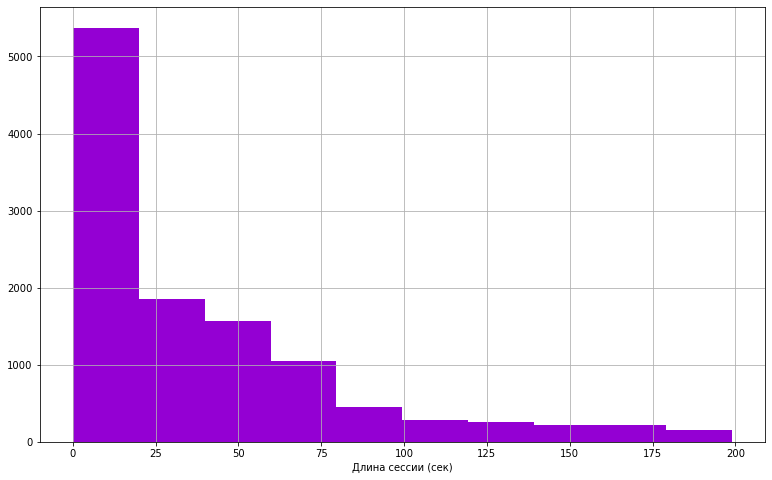

In [ ]:
train_data_10users['session_timespan'][train_data_10users.session_timespan < 200].hist(color='darkviolet')
plt.xlabel('Длина сессии (сек)');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

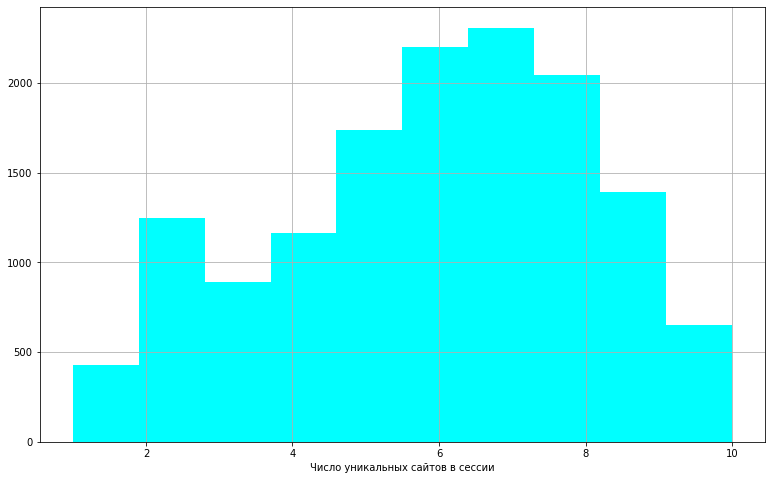

In [ ]:
train_data_10users['#unique_sites'].hist(color='aqua')
plt.xlabel('Число уникальных сайтов в сессии');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

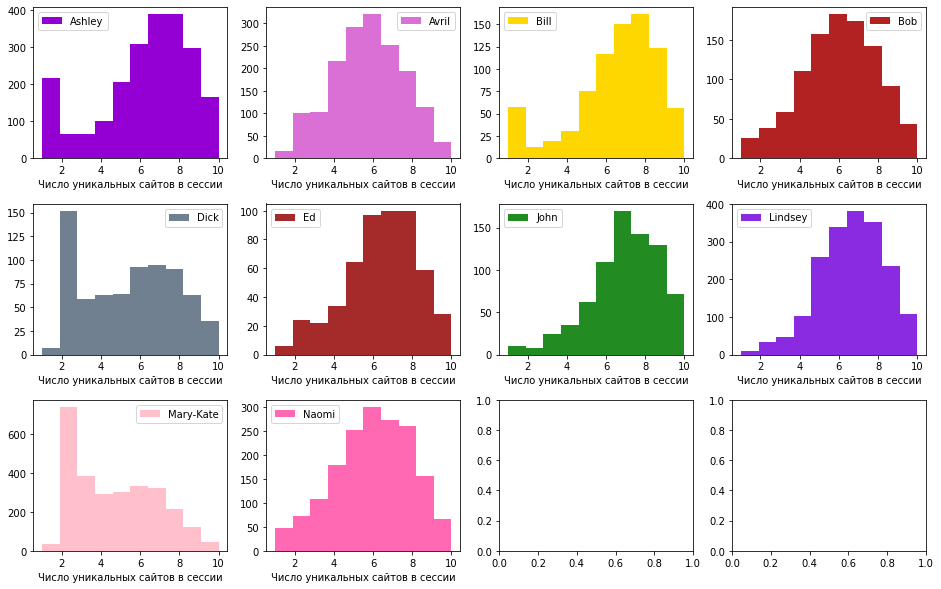

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    axes[idx//4, idx%4].hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('Число уникальных сайтов в сессии')

In [ ]:
# по-другому можно так
# train_data_10users.hist('#unique_sites', by='target', figsize=(16, 16));

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

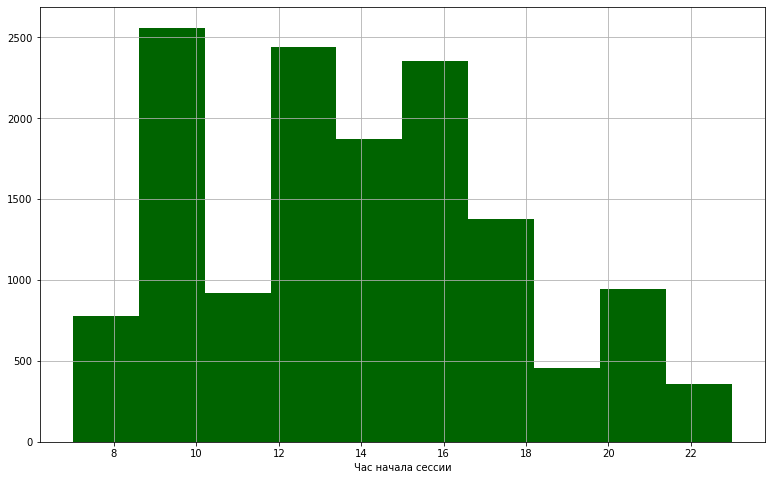

In [ ]:
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Час начала сессии');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

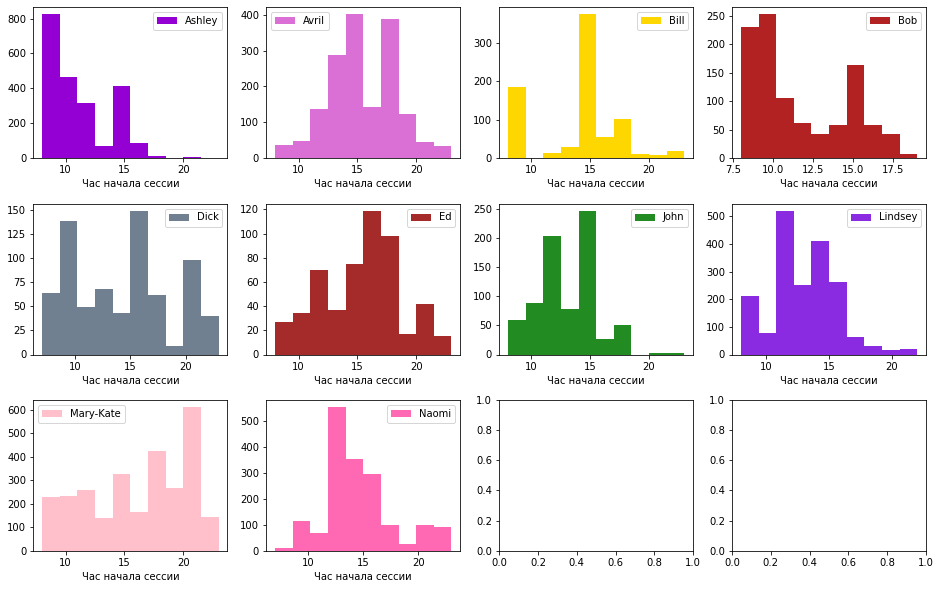

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    axes[idx//4, idx%4].hist(sub_df['start_hour'], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('Час начала сессии')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

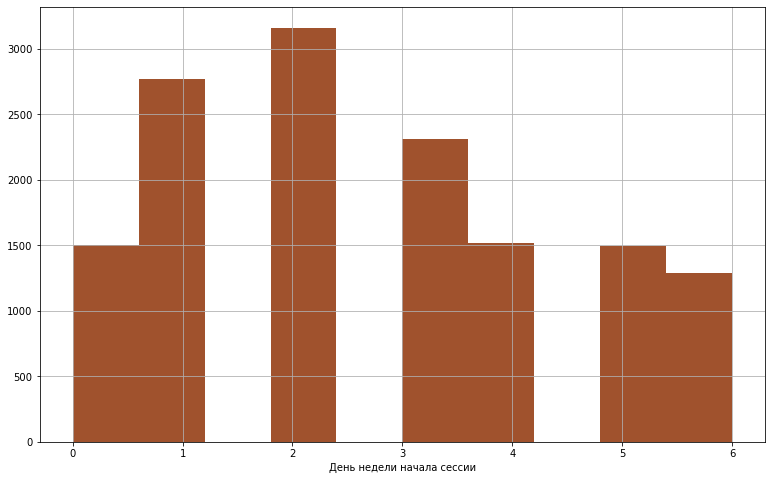

In [ ]:
train_data_10users['day_of_week'].hist(color='sienna')
plt.xlabel('День недели начала сессии');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

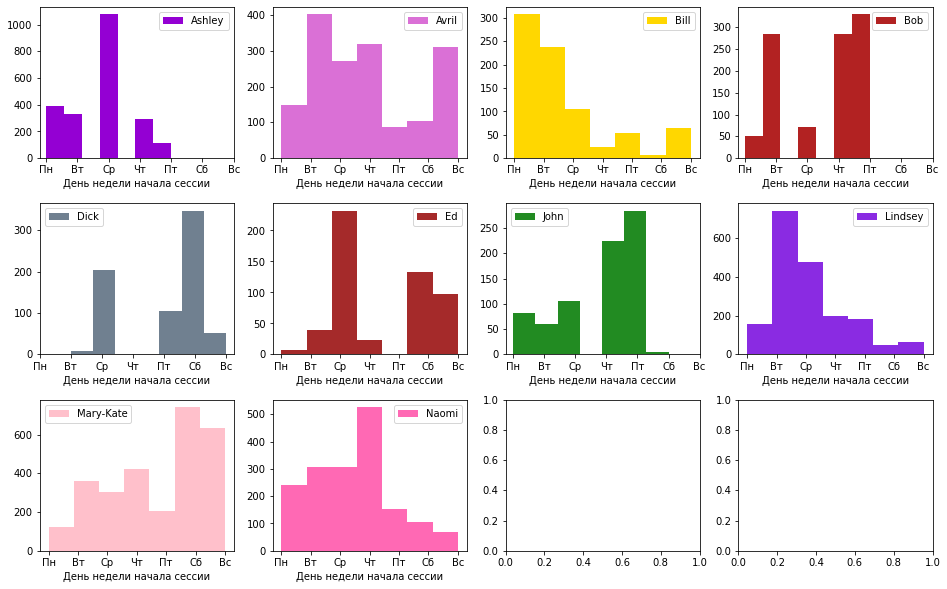

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    axes[idx//4, idx%4].hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins=7)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('День недели начала сессии')
    axes[idx//4, idx%4].set_xticks([0, 1, 2, 3, 4, 5, 6])
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

||Ashley|Avril|Bill|Bob|Dick|
|-|-|-|-|-|-|
|Посещение уникальных сайтов|Посещает в среднем 7 сайтов за сессию; также есть сессии с одним уникальным сайтом - пребывание на одном сайте|Распредение ~нормальное вокруг 6|Профиль похож на пользователя Ashley|Распредение ~нормальное вокруг 6|Мода - 2, распределение более равномерное|
|Время начала сессии|Начало сессии в основном приходится на утро; также большое количество сессий начинается около 15 (вероятно послеобеденное время), перед этим "яма"|Большинство сессий начинаются в середине дня|Начало сессий в основном приходится на 9 и 15 часов|Начало сессий в основном приходится на утро и 15 часов|Сесии начинаются в основном в 9, 15, 20 часов|
|День недели начала сессии|Сессии начинаются в будние дни, по выходным сессий нет|Сессии +- равномерно распределены по дням недели; пт, сб - "яма"|Сессии в основном начинаются в рабочие дни + вск|Сессии только по будним дням|Сессии чаще по средам и субботам|
|Возможное объяснение|Можно предположить что сессии связаны с рабочими задачами|Профиль ничем не примечателен|Можно предположить что сессии чаще связаны с рабочими задачами|Предположение: сессии связаны с рабочими задачами|Активное использование в течение дня, но чаще 2 дня в неделю; возможно рабочее использование интернета, но работа с особым графиком|

||Ed|John|Lindsey|Mary-Kate|Naomi|
|-|-|-|-|-|-|
|Посещение уникальных сайтов|Распредение ~нормальное вокруг 7|Распредение скошено вправо; в сессиях преобладают различные сайты|Аналогично пользователю John|Аналогично пользователю Dick|Распредение ~нормальное вокруг 6|
|Время начала сессии|Распредение похоже на нормальное вокруг 16 часов|Рабочее время с всплесками в 12 и 15 часов|Аналогично пользователю John|Количество сессий растёт к концу дня|Мода = 12|
|День недели начала сессии|В основном среда и выходные|Рабочие дни|В основном рабочие дни|Будние дни, но чаще в выходные|Будние дни|
|Возможное объяснение|График использования по дням похож на полдьзователя Dick|Рабочие задачи, вероятно, поиск информации на разных сайтах|В основном рабочие дни,есть, но меньше посещений в выходные|Можно предположить что использование интернеты связано в основном с личными делами|Рабочие задачи, но рабочий день начинается позже|

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [ ]:
site_freq_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10 = sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:10]
top10

[('s.youtube.com', (210, 8300)),
 ('www.google.fr', (51, 7813)),
 ('www.google.com', (4, 5441)),
 ('mail.google.com', (183, 4158)),
 ('www.facebook.com', (15, 4141)),
 ('apis.google.com', (52, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 3094)),
 ('plus.google.com', (187, 2630)),
 ('accounts.google.com', (184, 2089))]

In [ ]:
top10_freqs = [x[1][1] for x in top10]
top10_sites = [x[0] for x in top10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

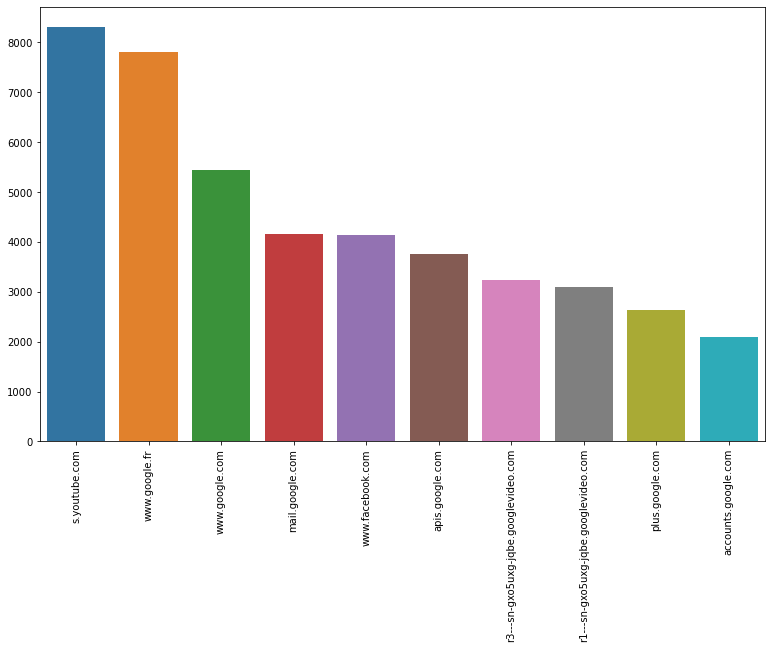

In [ ]:
chart = sns.barplot(x=top10_sites, y=top10_freqs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [ ]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [ ]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [ ]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [ ]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
# !unzip capstone_user_identification.zip

In [ ]:
# train_data_10users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), index_col='session_id')
# new_features_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'))
# new_new_features_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'new_new_features_10users.pkl'))
# train_data_10users = pd.concat([train_data_10users, new_features_10users, new_new_features_10users], axis=1)
# train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id,time_diff1,...,#unique_sites,start_hour,day_of_week,start_year,start_month,start_day,is_weekend,start_hour,day_time,visit_mean_time,facebook_visited,popular_share
0,1,2,3,4,3,3,4,3,5,3,31,10,...,5,8,4,2013,11,15,0,8,1,3.666667,0,0.0
1,6,7,8,9,3,10,11,12,13,14,31,1,...,10,8,4,2013,11,15,0,8,1,31.555556,0,0.0
2,14,4,14,14,15,16,6,17,18,14,31,0,...,7,8,4,2013,11,15,0,8,1,28.666667,0,0.0
3,19,20,19,14,14,14,14,21,22,23,31,2,...,6,8,4,2013,11,15,0,8,1,3.333333,0,0.0
4,24,14,15,25,26,27,28,29,30,29,31,1,...,9,8,4,2013,11,15,0,8,1,0.666667,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,4,183,52,184,51,185,4,52,186,3585,241,0,...,8,15,2,2014,3,26,0,15,2,3.000000,0,0.0
14057,184,185,3585,186,188,4,183,187,183,188,241,0,...,8,15,2,2014,3,26,0,15,2,1.222222,0,0.0
14058,189,183,187,52,184,615,187,189,183,183,241,1,...,6,15,2,2014,3,26,0,15,2,1.777778,0,0.0
14059,183,183,183,95,615,183,4,4,187,183,241,2,...,5,15,2,2014,3,26,0,15,2,26.888889,0,0.0


In [ ]:
# train_data_150users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), index_col='session_id')
# new_features_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'))
# new_new_features_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'new_new_features_150users.pkl'))
# train_data_150users = pd.concat([train_data_150users, new_features_150users, new_new_features_150users], axis=1)
# train_data_150users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id,time_diff1,...,#unique_sites,start_hour,day_of_week,start_year,start_month,start_day,is_weekend,start_hour,day_time,visit_mean_time,facebook_visited,popular_share
0,1,1,2,3,1,2,1,3,4,5,6,1,...,5,8,4,2013,11,15,0,8,1,6.333333,0,0.0
1,3,6,7,4,5,5,8,9,10,10,6,0,...,8,8,4,2013,11,15,0,8,1,179.777778,0,0.0
2,5,11,1,1,1,1,9,5,3,1,6,1,...,5,8,4,2013,11,15,0,8,1,223.333333,0,0.0
3,1,1,12,12,13,12,12,1,14,1,6,1,...,4,9,4,2013,11,15,0,9,1,222.888889,0,0.0
4,1,1,15,1,16,17,16,17,18,15,6,4,...,5,9,4,2013,11,15,0,9,1,1.111111,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137014,779,1390,1063,1393,779,1389,1390,1389,779,33,2902,0,...,6,17,0,2014,4,14,0,17,2,0.222222,0,0.0
137015,6,1390,33,449,2065,1393,297,3,1,1389,2902,0,...,10,17,0,2014,4,14,0,17,2,23.333333,0,0.0
137016,1389,1386,1389,1388,779,1271,58,1289,1540,314,2902,3,...,9,17,0,2014,4,14,0,17,2,0.666667,0,0.0
137017,41,779,1392,1063,779,1394,2064,297,1389,1390,2902,0,...,9,17,0,2014,4,14,0,17,2,0.444444,0,0.0


In [ ]:
site_freq_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))
site_freq_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))

In [ ]:
facebook_sites = {k: v for k, v in site_freq_10users.items() if 'facebook' in k}
facebook_sites

{'api-read.facebook.com': (3795, 4),
 'api.facebook.com': (1477, 52),
 'apps.facebook.com': (3794, 11),
 'ar-ar.facebook.com': (2851, 4),
 'badge.facebook.com': (573, 24),
 'connect.facebook.net': (64, 482),
 'developers.facebook.com': (2371, 4),
 'facebook.com': (1960, 20),
 'fr-fr.facebook.com': (614, 24),
 'fr.facebook.com': (4570, 3),
 'graph.facebook.com': (1344, 59),
 'l.facebook.com': (3828, 1),
 's-static.ak.facebook.com': (66, 1388),
 'static-0.facebook.com': (3827, 3),
 'static.ak.connect.facebook.com': (2666, 5),
 'static.ak.facebook.com': (63, 1265),
 'www.facebook.com': (15, 4141)}

In [ ]:
train_data_10users[train_data_10users.site1 == 15]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id,time_diff1,...,#unique_sites,start_hour,day_of_week,start_year,start_month,start_day,is_weekend,start_hour,day_time,visit_mean_time,facebook_visited,popular_share
85,15,8,197,16,5,198,14,199,145,200,31,0,...,10,13,3,2013,12,12,0,13,2,0.555556,0,0.0
135,15,249,248,66,63,64,10,52,248,250,31,0,...,9,11,4,2013,12,20,0,11,1,0.888889,0,0.0
162,15,286,285,52,72,286,299,285,300,301,31,1,...,8,11,4,2013,12,20,0,11,1,0.222222,0,0.0
173,15,72,51,300,227,289,300,51,4,227,31,4,...,7,11,4,2013,12,20,0,11,1,48.333333,0,0.0
200,15,63,252,335,351,351,319,335,72,351,31,0,...,7,12,4,2013,12,20,0,12,2,0.888889,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13823,15,1347,100,1348,1349,106,106,51,51,2036,241,1,...,8,13,5,2014,1,25,1,13,2,5.000000,0,0.0
13891,15,2691,64,66,2692,59,63,60,594,336,241,0,...,10,13,6,2014,1,26,1,13,2,0.111111,0,0.0
13892,15,336,15,1960,69,2691,59,15,2691,15,241,0,...,6,13,6,2014,1,26,1,13,2,0.333333,0,0.0
13903,15,2730,2730,51,70,847,2731,705,568,2713,241,0,...,9,14,6,2014,1,26,1,14,2,0.222222,0,0.0


Расширим генератор feature_engineering новыми признаками

In [ ]:
def feature_engineering(file, session_length, window_size, site_map, user_id):
    '''
    Генератор
    Создаёт признаки сессии:
    - список сайтов
    - время посещения сайта (разница во времени между посещениями сайтов)
    - длина сессии
    - количество уникальных сайтов в сессии
    - час начала сессии
    - день недели начала сессии
    - год начала сессии
    - месяц начала сессии
    - день начала сессии
    - выходной (бинарный)
    - время суток начала сессии
    - среднее время на сайте
    - посещение facebook (бинарный)
    - доля популярных сайтов в сессии
    
    - user_id: целевой признак
    '''
    windows_it = iter(file) # итератор по всему файлу (по строкам)
    i = 0

    while True:
        try:
            if i % window_size == 0: # начинаем писать сессию
                # разделяем итератор на два; новый итератор только по сессии (как вложенный цикл)
                windows_it, session_it = tee(windows_it)
                session = list(session_string(session_it, session_length))
                if session: # чтобы не возвращать в конце пустую строку
                    # обрабатываем сайты
                    sites_fact = list(map(lambda x: x.split(',')[1].strip(), session))
                    sites_ids = np.array([site_map[site] for site in sites_fact])
                    # список сайтов
                    sites = np.zeros(session_length)
                    sites[:len(sites_fact)] = sites_ids
                    # число уникальных сайтов
                    n_unique_sites = np.unique(sites_ids).size
                    # посещение facebook (бинарный)
                    facebook_sites = [v for k, v in site_freq_10users.items() if 'google' in k]
                    facebook_visited = (len(set(sites).intersection(set(facebook_sites))) > 0)
                    # доля популярных сайтов в сессии
                    top30 = [v[1] for v in sorted(site_map.items(), key=lambda x: x[1], reverse=True)[:30]]
                    popular_share = len(set(sites).intersection(set(top30))) / session_length
                    
                    # обрабатываем timestamp'ы
                    times_fact = list(map(lambda x: pd.to_datetime(x.split(',')[0].strip()), session))
                    timediffs = np.array([(times_fact[i+1] - times_fact[i]).seconds for i in range(len(times_fact) - 1)])
                    # список разниц времён - по сути время посещения каждого сайта (кроме последнего)
                    times = np.zeros(session_length - 1)
                    times[:len(timediffs)] = timediffs
                    # длина сессии (минус время посещения последнего сайта)
                    session_timespan = (times_fact[-1] - times_fact[0]).seconds
                    # час начала сессии
                    start_hour = times_fact[0].hour
                    # день недели начала сессии
                    start_day_of_week = times_fact[0].day_of_week
                    # год начала сессии
                    start_year = times_fact[0].year
                    # месяц начала сессии
                    start_month = times_fact[0].month
                    # день начала сессии
                    start_day = times_fact[0].day
                    # выходной (бинарный)
                    is_weekend = (start_day_of_week // 5 == 1)
                    # время суток
                    if start_hour >= 0 and start_hour < 6:     # ночь
                        day_time = 0
                    elif start_hour >= 6 and start_hour < 12:  # утро
                        day_time = 1
                    elif start_hour >= 12 and start_hour < 18: # день
                        day_time = 2
                    else:                                      # вечер
                        day_time = 3
                    # среднее время на сайте
                    visit_mean_time = timediffs.mean()
                    
                    yield np.concatenate((sites, times, [session_timespan], [n_unique_sites], 
                                          [start_hour], [start_day_of_week], [start_year], [start_month], [start_day],
                                          [is_weekend], [day_time], [visit_mean_time],
                                          [facebook_visited], [popular_share],
                                          [user_id]))
        except StopIteration:
            return

        try:
            next(windows_it)
            i += 1
        except StopIteration:
            return

In [ ]:
# проверка
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'start_day_of_week', 'start_year', 'start_month', 'start_day', 'is_weekend',
                 'day_time', 'visit_mean_time', 'facebook_visited', 'popular_share', 'target']
train_data_fe  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                                            site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                                            feature_names=feature_names, session_length=10)
train_data_fe

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,#unique_sites,start_hour,start_day_of_week,start_year,start_month,start_day,is_weekend,day_time,visit_mean_time,facebook_visited,popular_share,target


Применим новую функцию к данным по 10 пользователям

In [ ]:
%%time
train_data_10users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 27.7 s


Применим новую функцию к данным по 150 пользователям

In [ ]:
%%time
train_data_150users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/150 [00:00<?, ?it/s]

Wall time: 16min 36s


In [ ]:
new_new_features = ['start_year', 'start_month', 'start_day', 'is_weekend', 'start_hour',
                    'day_time', 'visit_mean_time', 'facebook_visited', 'popular_share']

In [ ]:
train_data_10users.iloc[:, 10:]

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,start_day_of_week,start_year,start_month,start_day,is_weekend,day_time,visit_mean_time,facebook_visited,popular_share,target
0,10,0,0,1,20,1,0,1,0,33,5,8,4,2013,11,15,0,1,3.666667,0,0.0,31
1,1,0,163,105,0,1,3,3,8,284,10,8,4,2013,11,15,0,1,31.555556,0,0.0,31
2,0,14,1,242,0,0,1,0,0,258,7,8,4,2013,11,15,0,1,28.666667,0,0.0,31
3,2,1,0,1,25,1,0,0,0,30,6,8,4,2013,11,15,0,1,3.333333,0,0.0,31
4,1,0,1,1,1,0,1,1,0,6,9,8,4,2013,11,15,0,1,0.666667,0,0.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,0,1,0,1,0,1,23,1,0,27,8,15,2,2014,3,26,0,2,3.000000,0,0.0,241
14057,0,0,2,0,0,0,2,1,6,11,8,15,2,2014,3,26,0,2,1.222222,0,0.0,241
14058,1,1,0,0,1,0,0,5,8,16,6,15,2,2014,3,26,0,2,1.777778,0,0.0,241
14059,2,1,51,173,1,12,1,1,0,242,5,15,2,2014,3,26,0,2,26.888889,0,0.0,241


In [ ]:
train_data_10users[new_new_features]

,start_year,start_month,start_day,is_weekend,start_hour,day_time,visit_mean_time,facebook_visited,popular_share
0,2013,11,15,0,8,1,3.666667,0,0.0
1,2013,11,15,0,8,1,31.555556,0,0.0
2,2013,11,15,0,8,1,28.666667,0,0.0
3,2013,11,15,0,8,1,3.333333,0,0.0
4,2013,11,15,0,8,1,0.666667,0,0.0
...,...,...,...,...,...,...,...,...,...
14056,2014,3,26,0,15,2,3.000000,0,0.0
14057,2014,3,26,0,15,2,1.222222,0,0.0
14058,2014,3,26,0,15,2,1.777778,0,0.0
14059,2014,3,26,0,15,2,26.888889,0,0.0


In [ ]:
new_features_10users = train_data_10users[new_new_features]

In [ ]:
new_features_10users

,start_year,start_month,start_day,is_weekend,start_hour,day_time,visit_mean_time,facebook_visited,popular_share
0,2013,11,15,0,8,1,3.666667,0,0.0
1,2013,11,15,0,8,1,31.555556,0,0.0
2,2013,11,15,0,8,1,28.666667,0,0.0
3,2013,11,15,0,8,1,3.333333,0,0.0
4,2013,11,15,0,8,1,0.666667,0,0.0
...,...,...,...,...,...,...,...,...,...
14056,2014,3,26,0,15,2,3.000000,0,0.0
14057,2014,3,26,0,15,2,1.222222,0,0.0
14058,2014,3,26,0,15,2,1.777778,0,0.0
14059,2014,3,26,0,15,2,26.888889,0,0.0


In [ ]:
new_features_150users = train_data_150users[new_new_features]

In [ ]:
with open(os.path.join(PATH_TO_DATA, 'new_new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
train_data_10users.facebook_visited.value_counts()

0    14061
Name: facebook_visited, dtype: int64

**Год начала сессии**

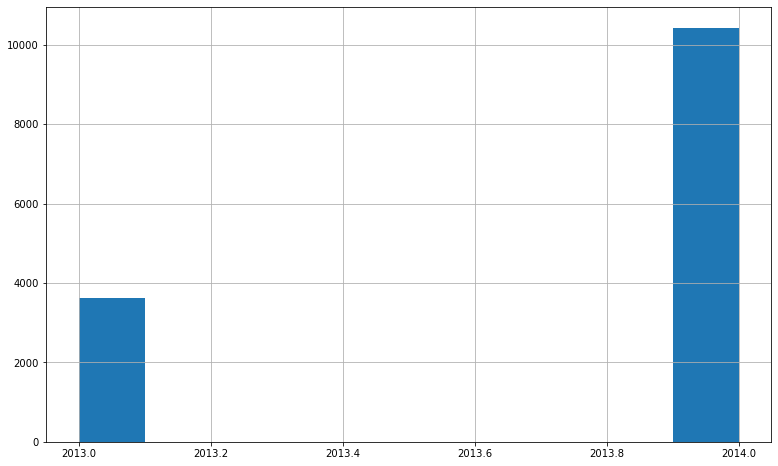

In [ ]:
train_data_10users.start_year.hist();

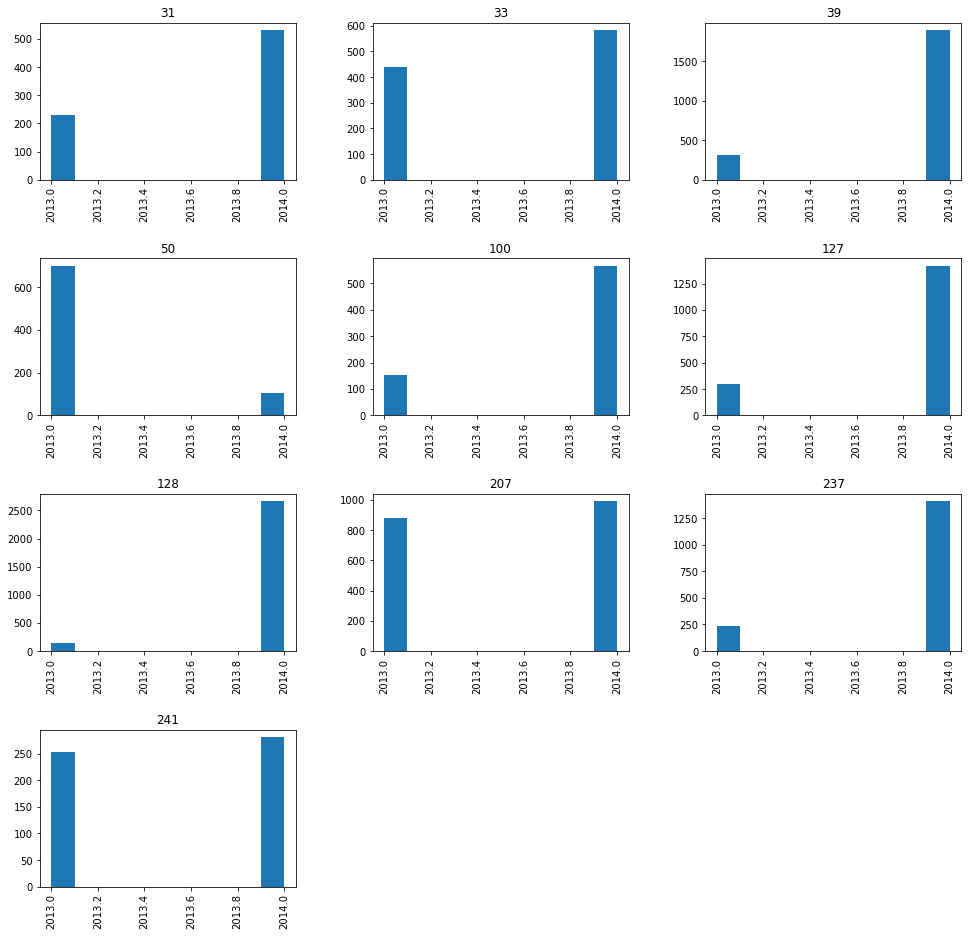

In [ ]:
train_data_10users.hist('start_year', by='target', figsize=(16, 16));

**Месяц начала сессии**

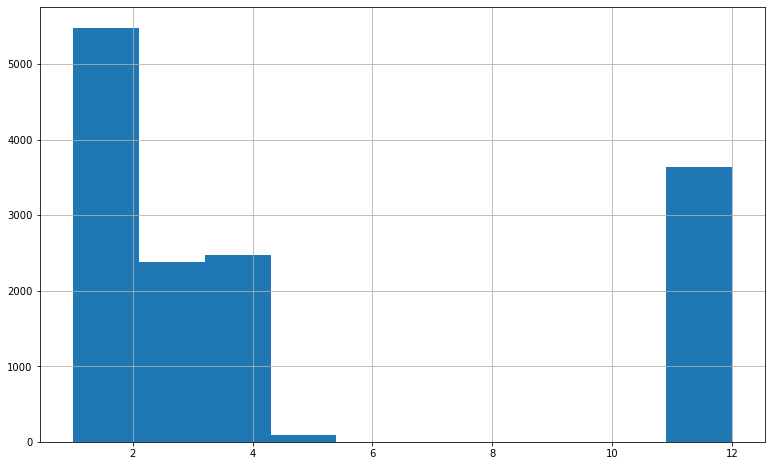

In [ ]:
train_data_10users.start_month.hist();

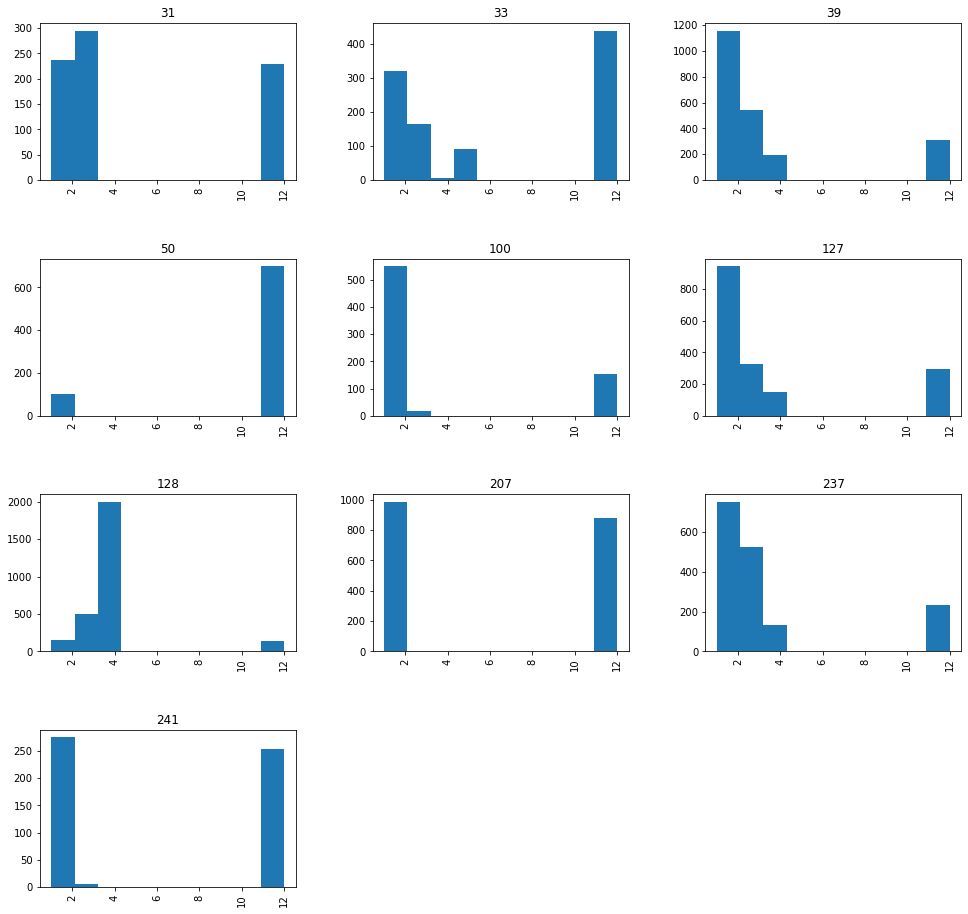

In [ ]:
train_data_10users.hist('start_month', by='target', figsize=(16, 16));

**День начала сессии**

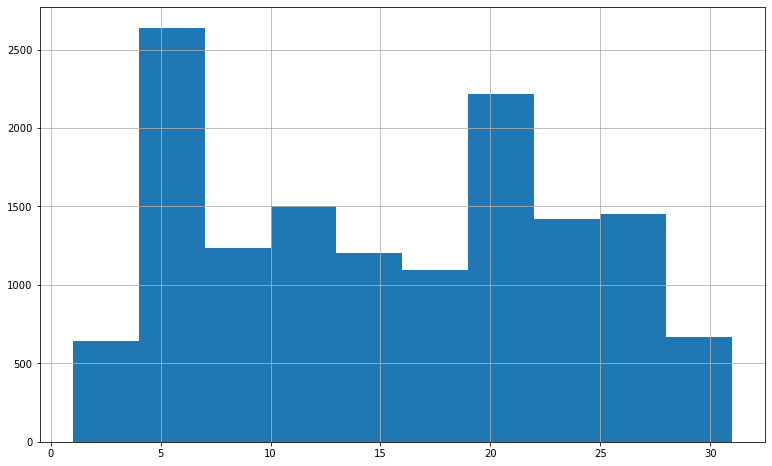

In [ ]:
train_data_10users.start_day.hist();

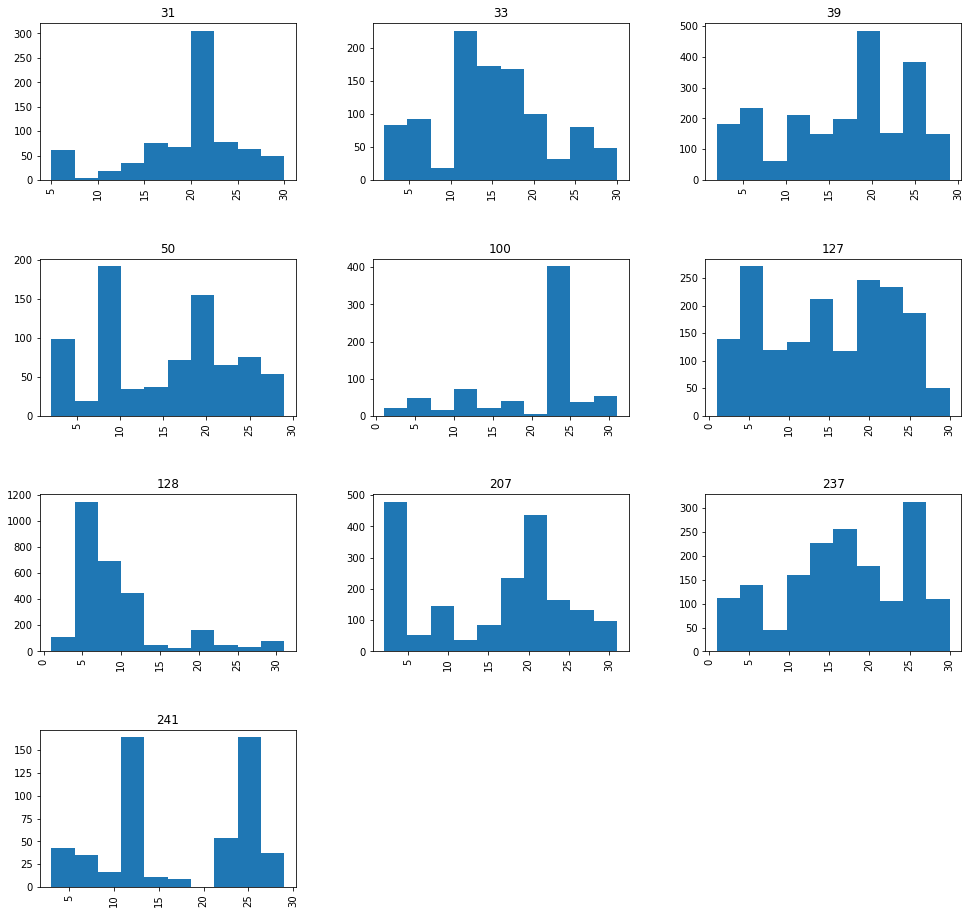

In [ ]:
train_data_10users.hist('start_day', by='target', figsize=(16, 16));

**Выходной**

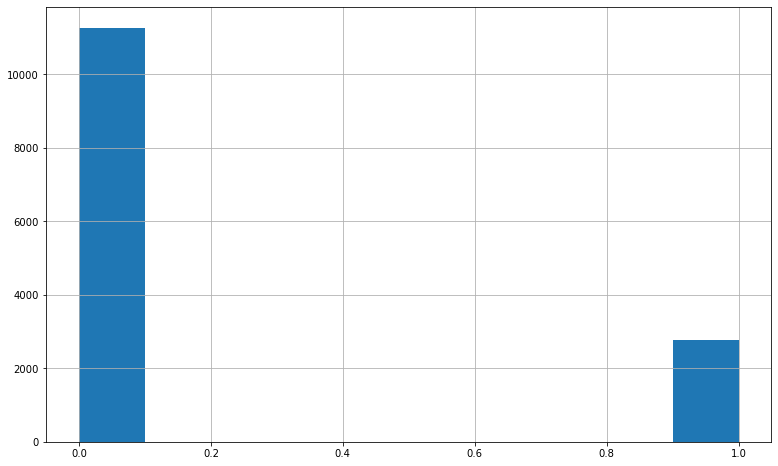

In [ ]:
train_data_10users.is_weekend.hist();

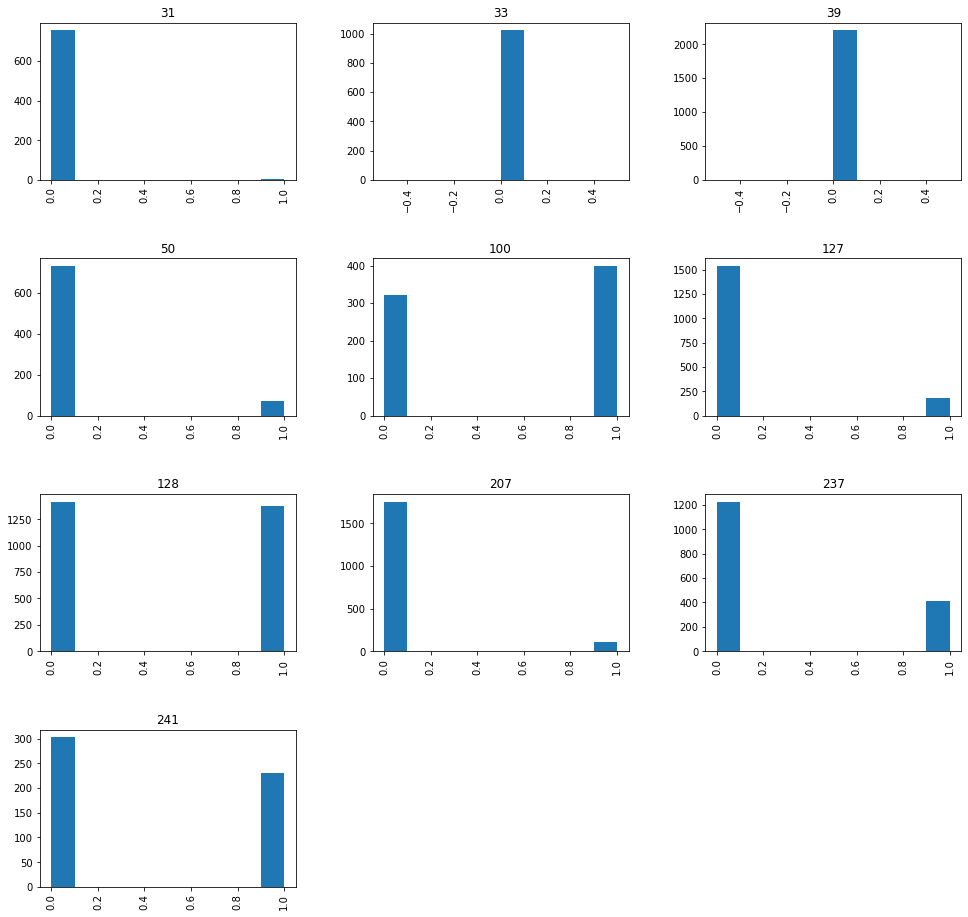

In [ ]:
train_data_10users.hist('is_weekend', by='target', figsize=(16, 16))

**Час начала сессии**

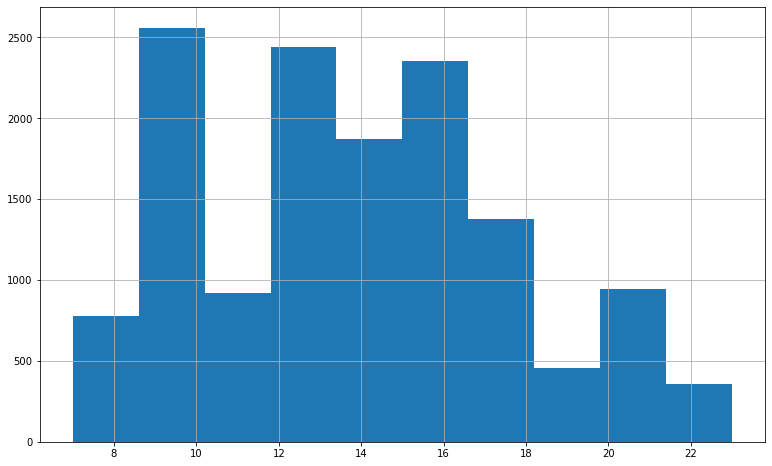

In [ ]:
train_data_10users.start_hour.hist();

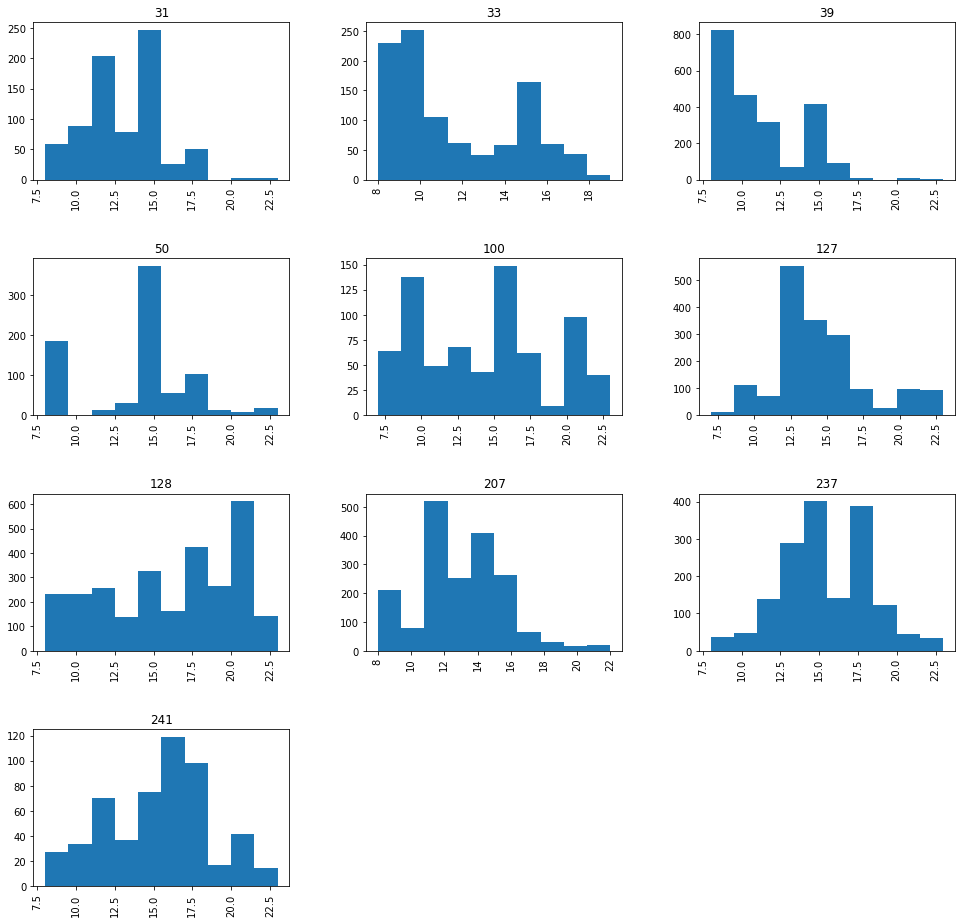

In [ ]:
train_data_10users.hist('start_hour', by='target', figsize=(16, 16));

**Время суток**

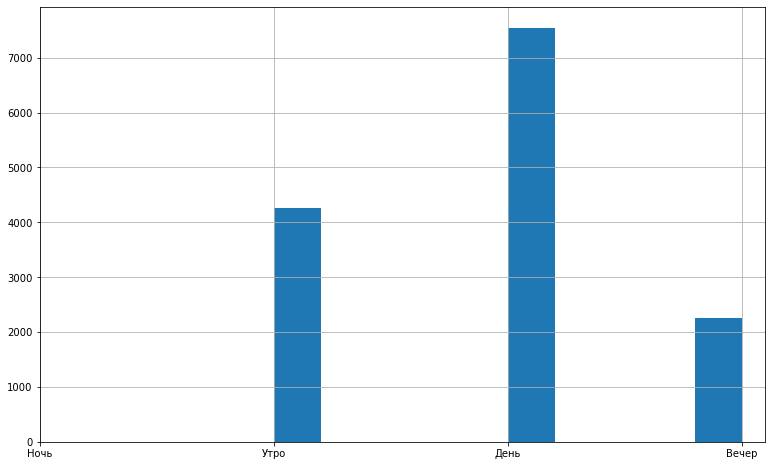

In [ ]:
train_data_10users.day_time.hist()
plt.xticks([0, 1, 2, 3], labels=['Ночь', 'Утро', 'День', 'Вечер']);

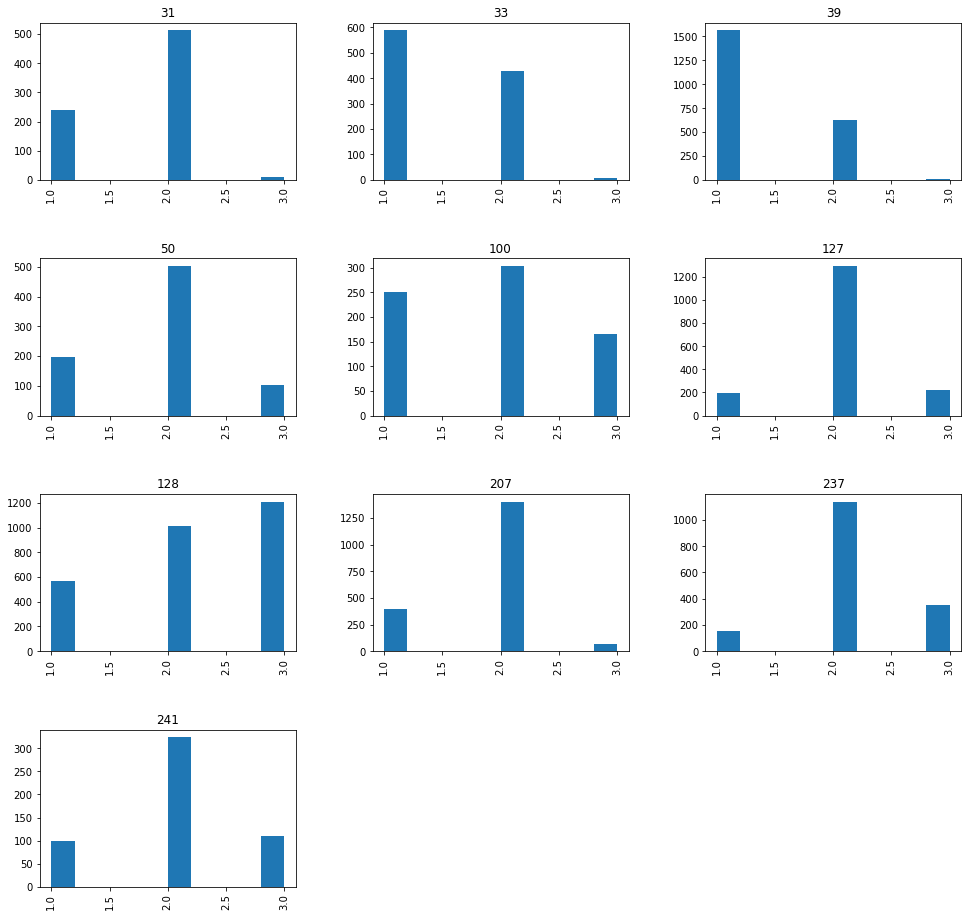

In [ ]:
train_data_10users.hist('day_time', by='target', figsize=(16, 16));

**Среднее время посещения сайта**

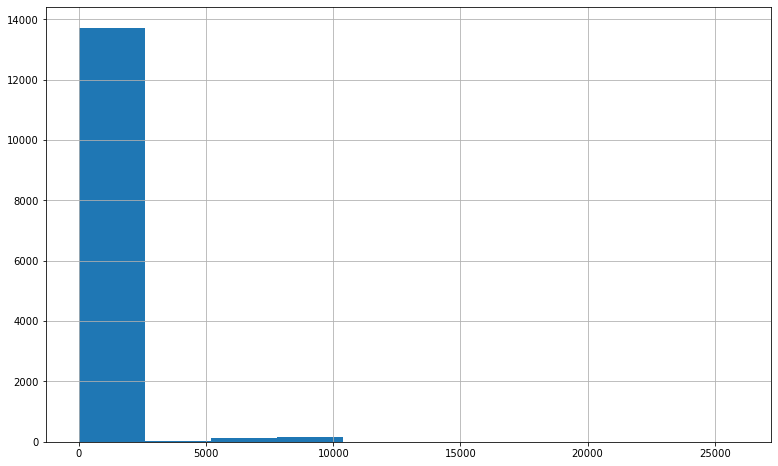

In [ ]:
train_data_10users.visit_mean_time.hist();

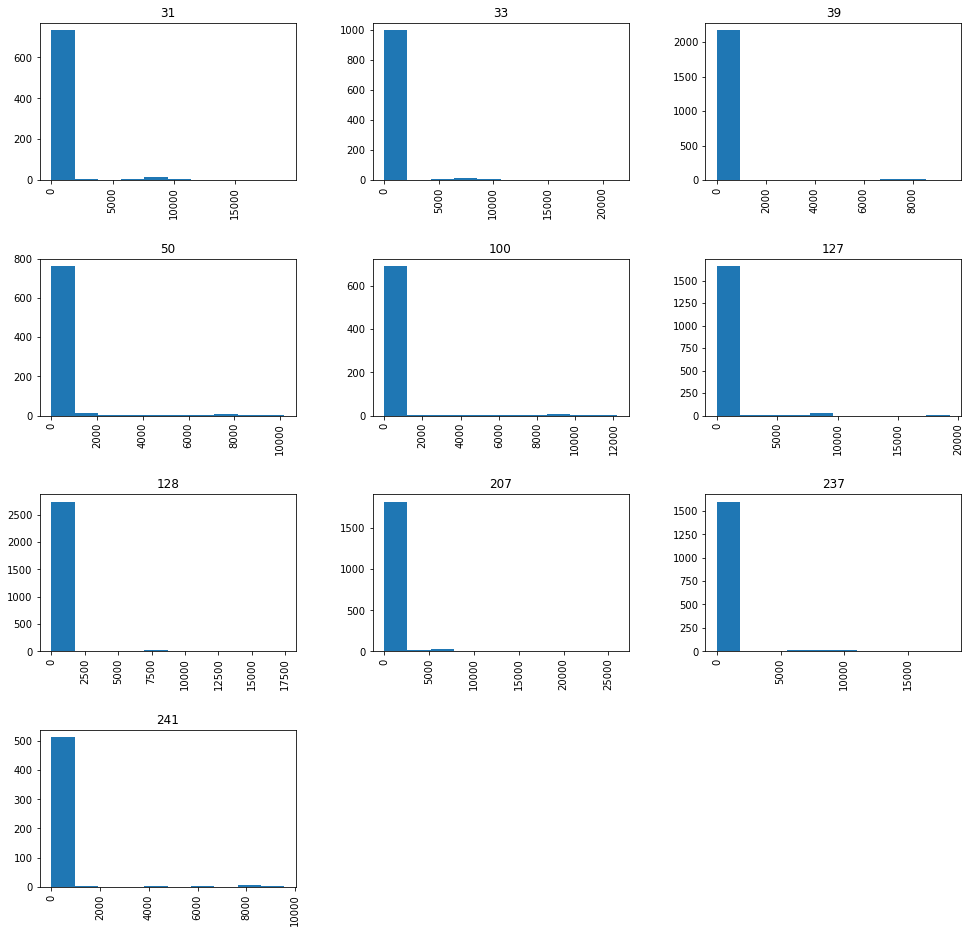

In [ ]:
train_data_10users.hist('visit_mean_time', by='target', figsize=(16, 16));

**Индикатор посещения Facebook**

In [ ]:
new_new_features

['start_year',
 'start_month',
 'start_day',
 'is_weekend',
 'start_hour',
 'day_time',
 'visit_mean_time',
 'facebook_visited',
 'popular_share']

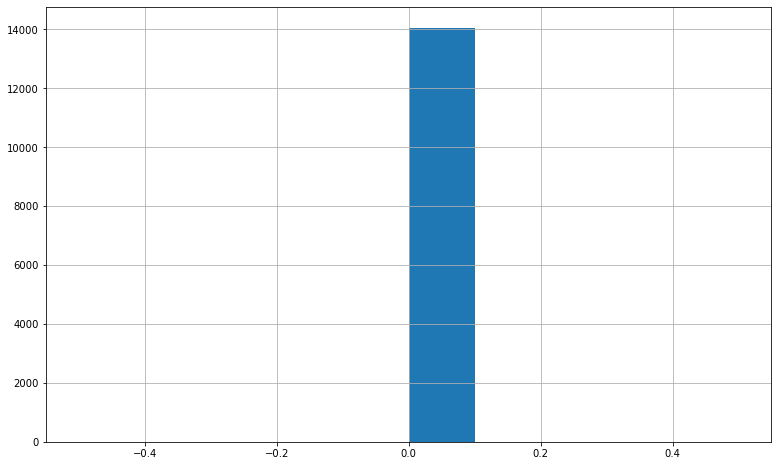

In [ ]:
train_data_10users.facebook_visited.hist();

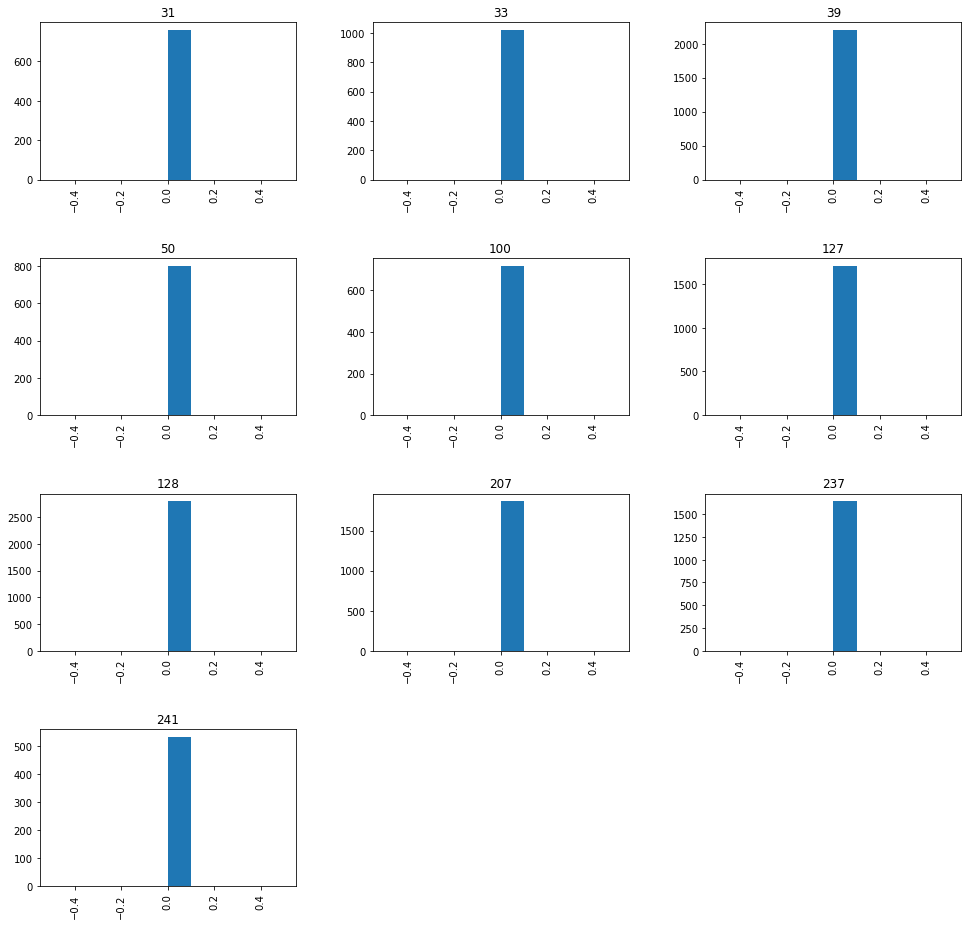

In [ ]:
train_data_10users.hist('facebook_visited', by='target', figsize=(16, 16));

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 